In [210]:
import random
import itertools
import matplotlib.pyplot as plt
import networkx as nx

In [211]:
num_columns = 4
grid_size = 30
min_room_size = 3

roomspace = grid_size - (num_columns + 1)
def all_less_then(comb,n):
    for i in comb:
        if i<n:
            return False
    return True

def get_divisions(n, k):
    divisions = []
    combs = itertools.product(range(1, n), repeat=k)
    dic={}
    for comb in combs:
        if sum(comb) == n and all_less_then(comb,min_room_size):
            dic["".join(map(str,sorted(comb)))]=comb
    return list(dic.values())

divisions = get_divisions(roomspace, num_columns)


horizontal_split = list(random.choice(divisions))
vertical_splits = [list(random.choice(divisions)) for i in horizontal_split]
random.shuffle(horizontal_split)
for split in vertical_splits:
    random.shuffle(split)

horizontal_data = []
x_accum = 1
for part in horizontal_split:
    horizontal_data.append((x_accum,part))
    x_accum += part+1

vertical_data = []
for split in vertical_splits:
    y_accum = 1
    data = []
    for part in split:
        data.append((y_accum,part))
        y_accum += part+1
    vertical_data.append(data)
divisions = get_divisions(roomspace, num_columns)

In [212]:
num_rooms = 5

horizontal_split = list(random.choice(divisions))
vertical_splits = [list(random.choice(divisions)) for i in horizontal_split]
random.shuffle(horizontal_split)
for split in vertical_splits:
    random.shuffle(split)

horizontal_data = []
x_accum = 1
for part in horizontal_split:
    horizontal_data.append((x_accum,part))
    x_accum += part+1

vertical_data = []
for split in vertical_splits:
    y_accum = 1
    data = []
    for part in split:
        data.append((y_accum,part))
        y_accum += part+1
    vertical_data.append(data)


chosen_cells = 0
rooms_ixs = []

while True:
    x = random.choice(range(len(horizontal_split)))
    y = random.choice(range(len(vertical_splits[x])))
    ix = (x,y)
    if ix not in rooms_ixs:
        rooms_ixs.append(ix)
    if len(rooms_ixs) == num_rooms:
        break

chosen_rooms = []
for ix_x,ix_y in rooms_ixs:
    x,w = horizontal_data[ix_x]
    y,h = vertical_data[ix_x][ix_y]
    chosen_rooms.append((y,x,h,w))

def get_points(part):
    points = []
    y = part[0]
    x = part[1]
    for i in range(part[2]):
        for j in range(part[3]):
            points.append((y+i,x+j))
    return points
            
    
walkable_points = []
for w in chosen_rooms:
    walkable_points += get_points(w)
walkable_points = set(walkable_points)

def create_string(walkable):
    string = ""
    for i in range(grid_size):
        for j in range(grid_size):
            if (i,j) in walkable:
                string += " "
            else: string += "#"
        string += "\n"
    return string

print(create_string(walkable_points))

##############################
##########################   #
##########################   #
##########################   #
##########################   #
###################      #   #
###################      #####
###################      #####
###################      #####
###################      #####
###################      #####
##############################
##############################
##############################
##########################   #
##########################   #
#############     ########   #
#############     ########   #
#############     ########   #
#############     ########   #
#############     ########   #
#############     ########   #
##########################   #
#############     ########   #
#############     ############
#############     ############
#############     ############
#############     ############
#############     ############
##############################



In [213]:
def toG(y,x):
    return y-1,x-1
def toL(p):
    y,x = p
    return y+1,x+1
def get_room_center(room):
    y,x,h,w=room
    cy = y + (h//2)
    cx = x + (w//2)
    return (cy,cx)

In [214]:
import numpy as np
from scipy.spatial.distance import cdist

def get_distance(r1,r2):
    A = np.array(get_points(r1))
    B = np.array(get_points(r2))
    distances = cdist(A, B)
    min_distance = np.min(distances)
    return min_distance

distances = {}
for i,r1 in enumerate(chosen_rooms):
    for j,r2 in enumerate(chosen_rooms):
        if i<j:
            distances[(i,j)]=get_distance(r1,r2)


In [215]:
sorted_pairs=list(sorted(map(lambda x:(x[0],x[1]),distances.items()),key=lambda x:x[1]))

In [228]:
G.nodes

NodeView(((0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (4, 0), (4, 1), (4, 2)

In [245]:
def get_neighs(p):
    x,y = p
    neighbors = [(x + dx, y + dy) for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]]
    return neighbors

def get_path_border(path):
    border = []
    for p in path:
        border += get_neighs(p)
    surrounding_nodes = list(set(border)-set(path))
    return surrounding_nodes

def get_connecting_edges(surrounding_nodes):
    ret = []
    for node in surrounding_nodes:
        x,y = node
        neighbors = get_neighs((x,y))
        for neighbor in neighbors:
            if neighbor in surrounding_nodes:
                ret.append((node, neighbor))
    return ret

def get_path_border(path):
    border = []
    for p in path:
        border += get_neighs(p)
    surrounding_nodes = list(set(border)-set(path))
    return get_connecting_edges(surrounding_nodes)


def get_room_border(graph, room):
    y, x, h, w = room
    y,x = toG(y,x)
    surrounding_nodes = [(y - 1 + i, x - 1 + j) for i in range(h + 2) for j in range(w + 2) if i in [0, h + 1] or j in [0, w + 1]]
    return get_connecting_edges(surrounding_nodes)


In [247]:
import networkx as nx
G=nx.grid_graph(dim=[grid_size-2,grid_size-2])

for e in G.edges(data=True):
    e[2]['weigth']=1
for n,d in G.nodes(data=True):
    d['taken']=False
for y,x in walkable_points:
    G.nodes[(y-1,x-1)]['taken']=True

def set_weights(G,taken,weigth):
    for node in taken:
        for k,v in G[node].items(): #edges connected to the node
            if G.nodes[k]['taken']==True: #ignore if the node on the other side is already taken
                  continue
            else:
                v['weigth']+=weigth
    return G

def out_of_bounds(indices):
    for i in indices:
        if i<0 or i>grid_size-3:
            return True
    return False

def set_weight_edges(G,edges,weigth):
    for e in edges:
        indices=set(list(e[0])+list(e[1]))
        if out_of_bounds(indices):
            continue
        if G.nodes[e[0]]['taken']==True or G.nodes[e[1]]['taken']==True:
            continue
        G.edges[e]['weigth']=weigth
    return G 

edges_around_rooms = []
for room in chosen_rooms:
    edges_around_rooms+=get_room_border(G,room)
G = set_weight_edges(G,edges_around_rooms,100)    
rooms_points =  map(lambda x:x[0],filter(lambda d: d[1]['taken'] == True, G.nodes(data=True)))
G = set_weights(G,rooms_points,100)

In [249]:
paths = {}
for pair,_ in sorted_pairs:
    r1 = chosen_rooms[pair[0]]
    r2 = chosen_rooms[pair[1]]
    c1=get_room_center(r1)
    c2=get_room_center(r2)
    path=nx.shortest_path(G, source=c1, target=c2, weight='weigth')
    paths[pair]=path
    for y,x in path:
        G.nodes[(y,x)]['taken']=True
    G = set_weight_edges(G,get_path_border(path),100)
    G=set_weights(G,path,50)

In [218]:
paths

{(0, 1): [(19, 15),
  (20, 15),
  (21, 15),
  (22, 15),
  (23, 15),
  (24, 15),
  (25, 15),
  (26, 15)],
 (3, 4): [(3, 27),
  (3, 26),
  (3, 25),
  (4, 25),
  (4, 24),
  (4, 23),
  (4, 22),
  (5, 22),
  (6, 22),
  (7, 22),
  (8, 22)],
 (2, 4): [(19, 27),
  (18, 27),
  (17, 27),
  (16, 27),
  (15, 27),
  (14, 27),
  (14, 26),
  (14, 25),
  (14, 24),
  (14, 23),
  (13, 23),
  (12, 23),
  (11, 23),
  (10, 23),
  (9, 23),
  (9, 22),
  (8, 22)],
 (0, 4): [(19, 15),
  (18, 15),
  (17, 15),
  (16, 15),
  (15, 15),
  (14, 15),
  (13, 15),
  (12, 15),
  (11, 15),
  (10, 15),
  (9, 15),
  (9, 16),
  (9, 17),
  (9, 18),
  (8, 18),
  (8, 19),
  (8, 20),
  (8, 21),
  (8, 22)],
 (0, 2): [(19, 15),
  (19, 16),
  (19, 17),
  (19, 18),
  (19, 19),
  (19, 20),
  (19, 21),
  (19, 22),
  (19, 23),
  (19, 24),
  (19, 25),
  (19, 26),
  (19, 27)],
 (1, 2): [(26, 15),
  (25, 15),
  (24, 15),
  (23, 15),
  (22, 15),
  (22, 16),
  (22, 17),
  (22, 18),
  (22, 19),
  (22, 20),
  (22, 21),
  (22, 22),
  (22, 23)

In [219]:
G.edges[((0,0),(0,1))]

{'weigth': 1}

In [260]:
ix = 3
walkable_points1 = set(list(walkable_points) + list(map(toL,paths[sorted_pairs[ix][0]])))
print(create_string(walkable_points1))

##############################
###############   ############
###############   ############
###############   ############
###############   ############
##############################
#####         ############   #
#   #         ############   #
#   #         ############   #
#   #         ############   #
#####         ############   #
#             ############   #
#   ######################   #
#   ###############      #   #
###################      #####
#   ###############      #####
#   ##########################
#   ##########################
#   ###########   ############
#   ###########   ############
#   ###########   ############
#   ###########   ############
#   ###########   ############
#   ###########   ############
#   ##########################
##############################
###################      #####
###################      #####
###################      #####
##############################



In [241]:
get_path_border(paths[(0,4)])

[(7, 3),
 (10, 8),
 (10, 9),
 (10, 5),
 (10, 4),
 (8, 1),
 (10, 7),
 (9, 2),
 (10, 6),
 (9, 3),
 (8, 9),
 (9, 10),
 (7, 4),
 (8, 8),
 (8, 7),
 (8, 6),
 (8, 5),
 (7, 2)]

In [261]:
paths_lst = [(k, v) for k, v in paths.items()]

transformed_points = []
for room in chosen_rooms:
    points = get_points(room)
    transformed_points.append(list(map(lambda x:toG(x[0], x[1]), points)))
    

def checkIntersection(setA, setB):
    intersection = setA.intersection(set(setB).union(set(get_path_border(setB))))
    if len(intersection) > 0:
        return True
    return False



In [268]:
import itertools
import networkx as nx
edge_id = 0
# 1
room_G = nx.Graph()
for i, room in enumerate(chosen_rooms):
    room_G.add_node(i, room=room)
# 2
for corridor_key, corridor_points in paths_lst:
    start_room_index = corridor_key[0]
    end_room_index = corridor_key[1]
    # 3
    corridor_points = set(corridor_points)
    # 4, 5, 6
    start_room_points = set(transformed_points[start_room_index])
    end_room_points = set(transformed_points[end_room_index])
    corridor_points -= start_room_points
    corridor_points -= end_room_points

    # 7
    crossed_corridors = []
    crossed_rooms = []
    for i, room in enumerate(transformed_points):
        room_points = set(room)
        if checkIntersection(room_points, corridor_points):
            crossed_rooms.append(i)

    for j, path in enumerate(paths_lst):
        if edge_id == j:
            continue
        path_points = set(path[1])
        if checkIntersection(path_points, corridor_points):
            crossed_corridors.append(j)
    room_G.add_edge(start_room_index, end_room_index, corridor_key=edge_id, crossed_corridors=crossed_corridors, crossed_rooms=crossed_rooms)
    edge_id += 1
    print(corridor_key)
print(crossed_rooms)
print(crossed_corridors)

(0, 4)
(0, 5)
(1, 7)
(4, 5)
(5, 8)
(2, 4)
(1, 6)
(3, 6)
(4, 8)
(0, 8)
(1, 4)
(4, 6)
(1, 2)
(2, 7)
(6, 7)
(1, 3)
(6, 8)
(0, 2)
(4, 7)
(5, 6)
(3, 7)
(2, 5)
(2, 6)
(0, 6)
(1, 5)
(1, 8)
(3, 8)
(3, 4)
(2, 8)
(0, 1)
(3, 5)
(2, 3)
(0, 7)
(5, 7)
(7, 8)
(0, 3)
[4]
[0, 3, 8, 11, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34]


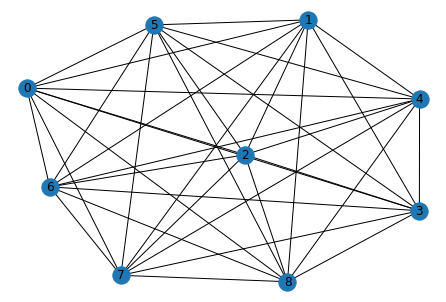

In [269]:
nx.draw(room_G, with_labels=True)
edgs=room_G.edges(data=True)

In [270]:
for e in edgs:
    print(e)

(0, 4, {'corridor_key': 0, 'crossed_corridors': [23, 29, 35], 'crossed_rooms': []})
(0, 5, {'corridor_key': 1, 'crossed_corridors': [], 'crossed_rooms': []})
(0, 8, {'corridor_key': 9, 'crossed_corridors': [4, 30], 'crossed_rooms': [5]})
(0, 2, {'corridor_key': 17, 'crossed_corridors': [32], 'crossed_rooms': []})
(0, 6, {'corridor_key': 23, 'crossed_corridors': [0, 3, 8, 11, 19, 21, 24, 25, 27, 28, 29, 33, 35], 'crossed_rooms': [4]})
(0, 1, {'corridor_key': 29, 'crossed_corridors': [0, 3, 8, 10, 11, 19, 21, 22, 23, 24, 25, 27, 28, 33, 35], 'crossed_rooms': [4]})
(0, 7, {'corridor_key': 32, 'crossed_corridors': [13, 17, 18, 31, 33], 'crossed_rooms': [2]})
(0, 3, {'corridor_key': 35, 'crossed_corridors': [0, 3, 8, 11, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34], 'crossed_rooms': [4]})
(1, 7, {'corridor_key': 2, 'crossed_corridors': [], 'crossed_rooms': []})
(1, 6, {'corridor_key': 6, 'crossed_corridors': [14, 34], 'crossed_rooms': []})
(1, 4, {'corridor_key': 10, 'crossed_corrido

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def _expand(G, explored_nodes, explored_edges):
    """
    Expand existing solution by a process akin to BFS.

    Arguments:
    ----------
    G: networkx.Graph() instance
        full graph

    explored_nodes: set of ints
        nodes visited

    explored_edges: set of 2-tuples
        edges visited

    Returns:
    --------
    solutions: list, where each entry in turns contains two sets corresponding to explored_nodes and explored_edges
        all possible expansions of explored_nodes and explored_edges

    """
    frontier_nodes = list()
    frontier_edges = list()
    for v in explored_nodes:
        for u in nx.neighbors(G,v):
            if not (u in explored_nodes):
                frontier_nodes.append(u)
                frontier_edges.append([(u,v), (v,u)])

    return zip([explored_nodes | frozenset([v]) for v in frontier_nodes], [explored_edges | frozenset(e) for e in frontier_edges])

def find_all_spanning_trees(G, root=0):
    """
    Find all spanning trees of a Graph.

    Arguments:
    ----------
    G: networkx.Graph() instance
        full graph

    Returns:
    ST: list of networkx.Graph() instances
        list of all spanning trees

    """

    # initialise solution
    explored_nodes = frozenset([root])
    explored_edges = frozenset([])
    solutions = [(explored_nodes, explored_edges)]
    # we need to expand solutions number_of_nodes-1 times
    for ii in range(G.number_of_nodes()-1):
        # get all new solutions
        solutions = [_expand(G, nodes, edges) for (nodes, edges) in solutions]
        # flatten nested structure and get unique expansions
        solutions = set([item for sublist in solutions for item in sublist])

    return [nx.from_edgelist(edges) for (nodes, edges) in solutions]




In [291]:
def get_valid_skeletons(G_room, room_indices):
    group = G_room.subgraph(room_indices)
    #nx.draw(group, with_labels=True)
    all_spanning_trees = find_all_spanning_trees(group, root=room_indices[0])
    valid_skeletons = []
    for spanning_tree in all_spanning_trees:
        edges = list(spanning_tree.edges())
        intersections = []
        corridor_keys = []
        valid_skeleton = True
        for edge_id in edges:
            edge = G_room[edge_id[0]][edge_id[1]]
            if all(n in room_indices for n in edge["crossed_rooms"]):
                intersections += edge["crossed_corridors"]
                corridor_keys.append(edge["corridor_key"])
            else:
                valid_skeleton = False
        if valid_skeleton:
            valid_skeletons.append({"edges": set(corridor_keys), "intersections": set(intersections)})
    return valid_skeletons



In [358]:
import itertools

available_indices = set(range(num_rooms))

def get_group_skeletons(available,group_size):
    combs = list(itertools.combinations(available,group_size))
    for c in combs:
        skels = get_valid_skeletons(room_G, list(c))
        if len(skels)!=0:
            yield (set(c),skels)
    return (False,False)

In [483]:
def iterate_G(available,group_sizes,i):
    group_size = group_sizes[0]
    group_sizes = group_sizes[1:]
    iterator = get_group_skeletons(available,group_size)
    for ixs,skels in iterator:
        if ixs == False:
            return []
        if len(group_sizes)!=0:
            available_ = available-ixs
            iterator_ = iterate_G(available_,group_sizes,i+1)
            finished = False
            for groups in iterator_:
                if len(groups) != 0:
                    groups.append({'vertices':ixs,'skeletons':skels})
                    yield groups
                else:
                    yield []
        else:
            yield [{'vertices':ixs,'skeletons':skels}] 

In [558]:
def get_possible_split(groups,intersections=set(),i=0):
    group = groups[0]
    if len(groups)==1:
        groups = []
    else:
        groups = groups[1:]
    for s1 in group['skeletons']:
        if len(s1['edges'].intersection(intersections))==0: # good
            if len(groups)!=0:
                it = get_possible_split(groups,intersections.union(s1['intersections']),i=i+1)
                for s2 in it:
                    s2.append(s1)
                    yield s2
            else:
                yield [s1]
        else:
            yield []
    return []
                    
            

In [575]:
splits_it = iterate_G(available_indices,[3,3,3],0)
found = False
for i,split in enumerate(splits_it):
    skels_it = get_possible_split(split)
    for skels in skels_it:
        if len(skels)==3:
            found = True
            print(i,'::::',skels)
            break
    #if i>100:
    if found==True:
        break


2 :::: [{'edges': {17, 12}, 'intersections': {32, 33, 18, 22}}, {'edges': {26, 4}, 'intersections': {35, 27, 30, 9}}, {'edges': {11, 14}, 'intersections': {34, 35, 6, 15, 19, 20, 23, 27, 31}}]


In [576]:
skels

[{'edges': {12, 17}, 'intersections': {18, 22, 32, 33}},
 {'edges': {4, 26}, 'intersections': {9, 27, 30, 35}},
 {'edges': {11, 14}, 'intersections': {6, 15, 19, 20, 23, 27, 31, 34, 35}}]

In [578]:
def get_crossing_edge(skels,groups):
        
    pass
    # skels is a list of skeletons for each group such as the one in the cell above
    # groups is a tuple of indices (i,j) of the groups which should be connected..it indexes the skels list
    # setA = get all vertices from group i
    # setB = get all vertices from group j
    # create all possible pairs (crossing edges) where the first element is from setA and the second from setB
    # iterate over the crossing edges (refered here as e):
    #   now when we speak about corridors we mean corridors which are present in the skeletons in the skel list
    #   these corridors are stored in the 'edges' key of a given skeleton 
    #   if the crossing_edge e intersets some room or corridor from some other group then i or j then skip this edge
    #   intA = get intersection between the crossing edge e and anythig (either room or chosen corridor) in group i
    #   intB = same thing but for group j
    #   if both intA and intB are not empty then skip this crossing edge
    #   else return this edge

((0, 2),
 [(8, 2),
  (7, 2),
  (6, 2),
  (5, 2),
  (4, 2),
  (3, 2),
  (2, 2),
  (2, 3),
  (2, 4),
  (2, 5),
  (2, 6),
  (2, 7),
  (2, 8),
  (2, 9),
  (2, 10),
  (2, 11),
  (2, 12),
  (2, 13),
  (2, 14),
  (3, 14),
  (3, 15),
  (3, 16)])

In [579]:

ix = 14
print(paths_lst[ix][0])
walkable_points1 = set(list(walkable_points) + list(map(toL,paths_lst[ix][1])))
print(create_string(walkable_points1))

(6, 7)
##############################
###############   ############
###############   ############
###############   ############
###############   ############
##############################
#####         ############   #
#   #         ############   #
#   #         ############   #
#   #         ############   #
#####         ############   #
#   #         ############   #
#   ######################   #
#   ###############      #   #
###################      ### #
#   ###############      #   #
#   #####################  ###
#   ###############       ####
#   ###########   # ##########
#   ###########   # ##########
#   ###########   # ##########
#   ###########   # ##########
#   ###########     ##########
#   ###########   ############
#   ##########################
##############################
###################      #####
###################      #####
###################      #####
##############################



In [562]:
paths_lst

[((0, 4),
  [(8, 2), (8, 3), (8, 4), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]),
 ((0, 5), [(8, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (12, 2)]),
 ((1, 7),
  [(14, 22),
   (13, 22),
   (12, 22),
   (12, 23),
   (11, 23),
   (10, 23),
   (10, 24),
   (10, 25),
   (10, 26),
   (10, 27)]),
 ((4, 5),
  [(9, 9),
   (9, 8),
   (9, 7),
   (9, 6),
   (9, 5),
   (9, 4),
   (10, 4),
   (10, 3),
   (10, 2),
   (11, 2),
   (12, 2)]),
 ((5, 8),
  [(12, 2),
   (12, 1),
   (12, 0),
   (13, 0),
   (14, 0),
   (15, 0),
   (16, 0),
   (17, 0),
   (18, 0),
   (19, 0),
   (20, 0),
   (20, 1),
   (20, 2)]),
 ((2, 4),
  [(3, 16),
   (3, 15),
   (3, 14),
   (4, 14),
   (5, 14),
   (6, 14),
   (7, 14),
   (8, 14),
   (9, 14),
   (9, 13),
   (9, 12),
   (9, 11),
   (9, 10),
   (9, 9)]),
 ((1, 6),
  [(14, 22),
   (14, 21),
   (14, 20),
   (14, 19),
   (14, 18),
   (15, 18),
   (16, 18),
   (17, 18),
   (18, 18),
   (19, 18),
   (20, 18),
   (21, 18),
   (21, 17),
   (21, 16)]),
 ((3, 6),
  [(27, 2